In [9]:
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

In [10]:
import os
from dotenv import load_dotenv
load_dotenv()


os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [11]:
#import Groq LLM
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama-3.1-8b-instant")
llm.invoke("Hello")

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.010694071, 'prompt_time': 0.001773694, 'queue_time': 0.050986766, 'total_time': 0.012467765}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--1390cb0f-7d52-4007-b20a-910cecdb0f2a-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})

| Part                            | Meaning                                |
| ------------------------------- | -------------------------------------- |
| `State`                         | Conversation memory structure          |
| `messages`                      | Stores chat messages                   |
| `Annotated[list, add_messages]` | Keeps adding messages like a real chatMeans "this is a list, but whenever new messages are added, append them instead of replacing them" — thanks to add_messages |


In [12]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

### We Will start With Creating Nodes

In [13]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

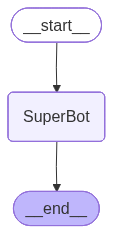

In [14]:
graph=StateGraph(State)# StateGraph creates a new graph that will follow the structure defined in State (which contains messages).
                       # This graph will control how messages move between nodes.

## node
graph.add_node("SuperBot",superbot) # Define a node named "SuperBot" that uses the def superbot(state:State): function to process messages.
## Edges

graph.add_edge(START,"SuperBot") # The graph starts at START 
graph.add_edge("SuperBot",END)   # Moves to SuperBot Ends at END (START ➝ SuperBot ➝ END)


graph_builder=graph.compile()


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png())) # Visualize the graph structure using Mermaid diagram in PNG format.

In [15]:
## Invocation

graph_builder.invoke({'messages':"Hi,My name is furqan And I like cricket"})

{'messages': [HumanMessage(content='Hi,My name is furqan And I like cricket', additional_kwargs={}, response_metadata={}, id='997107e7-b255-4b6b-8ecb-80fe51a46484'),
  AIMessage(content="Hello Furqan! Nice to meet you. Cricket is a fantastic sport, isn't it? There's something about the thrill of the game, the strategy, and the camaraderie that makes it so enjoyable. Are you a fan of any particular team or player? Do you have a favorite format of the game - Test cricket, One-Day Internationals (ODIs), or the Twenty20 format?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 47, 'total_tokens': 131, 'completion_time': 0.112959164, 'prompt_time': 0.002484975, 'queue_time': 0.053335125, 'total_time': 0.115444139}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_e32974efee', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--edf4b141-b9b4-4473-b616-6caaa25f1b1d-0', usage_metadata={'input_tokens

#### Streaming The responses

# What is `.stream()`?

`.stream()` is a method used to run your graph **step by step** and **see each update live as it happens**.
It lets you process **events in real time**—useful for understanding how your AI agent graph flows between nodes.

---

# When to use `.stream()`

| Use Case                      | Recommended?              |
| ----------------------------- | ------------------------- |
| Debug graph execution         | ✅ Yes                     |
| Real-time chat with AI agents | ✅ Yes                     |
| Understanding message flow    | ✅ Yes                     |
| Simple inference once         | ❌ Use `.invoke()` instead |

---

In [16]:
for event in graph_builder.stream({"messages":"Hello My name is furqan"}):
    print(event)

{'SuperBot': {'messages': [AIMessage(content="Hello Furqan, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 42, 'total_tokens': 70, 'completion_time': 0.02608405, 'prompt_time': 0.002071892, 'queue_time': 0.047468498, 'total_time': 0.028155942}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--fcb9bfdb-b677-4b7b-8077-f02ff073c4ab-0', usage_metadata={'input_tokens': 42, 'output_tokens': 28, 'total_tokens': 70})]}}


# This will **stream each event** (node execution, state update, or message) one by one.

### Final Understanding

This graph is a **simple AI agent pipeline**:

| Step     | What Happens                            |
| -------- | --------------------------------------- |
| START    | Begin execution                         |
| SuperBot | Process messages in `superbot` function |
| END      | Finish                                  |